## Projeto Machine Learning III

Autores:
- Ana Carolina Ferreira
- Diego Dio
- Fernando Brancher
- Marília Melo
- Mayara Medeiros

## Apresentação

**Objetivo:**

Criar modelos de classificação para prever se o tomador do empréstimo ficará inadimplente ou não.

Fonte de dados: https://www.kaggle.com/datasets/yasserh/loan-default-dataset

*Encontrei esse dicionário no projeto de outra pessoa, não é oficial, mas deve ajudar* (remover antes da apresnetação)

- **ID** = Customer ID of Applicant
- **year** = Year of Application
- **loan limit** = maximum avaliable amount of the loan allowed to be taken
- **Gender** = sex type
- **approv_in_adv** = Is loan pre-approved or not
- **loan_type** = Type of loan
- **loan_purpose** = the reason you want to borrow money
- **Credit_Worthiness** = is how a lender determines that you will default on your debt obligations, or how worthy you are to receive new credit.
- **open_credit** = is a pre-approved loan between a lender and a borrower. It allows the borrower to make repeated withdrawals up to a certain limit.
- **business_or_commercial** = Usage type of the loan amount
- **loan_amount** = The exact loan amount
- **rate_of_interest** = is the amount a lender charges a borrower and is a percentage of the principal—the amount loaned.
- **Interest_rate_spread** = the difference between the interest rate a financial institution pays to depositors and the interest rate it receives from loans
- **Upfront_charges** = Fee paid to a lender by a borrower as consideration for making a new loan
- **term** = the loan's repayment period
- **Neg_ammortization** = refers to a situation when a loan borrower makes a payment less than the standard installment set by the bank.
- **interest_only** = amount of interest only without principles
- **lump_sum_payment** = is an amount of money that is paid in one single payment rather than in installments.
- **property_value** = the present worth of future benefits arising from the ownership of the property
- **construction_type** = Collateral construction type
- **occupancy_type** = classifications refer to categorizing structures based on their usage
- **Secured_by** = Type of Collatoral
- **total_units** = number of unites
- **income** = refers to the amount of money, property, and other transfers of value received over a set period of time
- **credit_type** = type of credit
- **co-applicant_credit_type** = is an additional person involved in the loan application process. Both applicant and co-applicant apply and sign for the loan
- **age** = applicant's age
- **submission_of_application** = Ensure the application is complete or not
- **LTV** = life-time value (LTV) is a prognostication of the net profit
- **Region** = applicant's place
- **Security_Type** = Type of Collatoral
- **status** = Loan status (Approved/Declined)
- **dtir1** = debt-to-income ratio (percentage of income that will be compromised with the loan)

### Etapas projeto (apagar para apresentação final):
- Verificar uso de over/undersampling (não sei como faz nem onde se encaixaria)
- Considerando que temos mais de 150mil amostras, fazer uma subamostragem para análise exploratória, etapas subsequentes de testes de modelo, usando o dataset completo somente para rodar o modelo final com os hiperparâmetros já definidos. 
- Análise Exploratória inicial (atualizar análise após divisão do dataset em treino/teste)
    - describe
    - Mostrar dados em gráficos ao invés de tabelas
    - Distribuições de variáveis categóricas e numéricas
    - heatmap de correlação entre variáveis
- Column Transformer, divisão em X_train, X_test, y_train, y_test
    - Stratify no split de treino/teste devido ao desbalanceamento
    - Scaler (ver qual usar de acordo com as distribuições dos dados)
    - OneHot/Ordinal Encoder
- Seleção de features
- PCA para redução de dimensionalidade
- Modelo não supervisionado para verificar clusters de clientes e padrões no dataset
- Teste de 3 ou 4 modelos com grid/random search (lembrar que essa parte costuma demorar)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Pré-Processamento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer

# Instalar pacote missingno
# pip install missingno
import missingno as msno

# Feature Selection
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV

# PCA
from sklearn.decomposition import PCA

# Modelos
from sklearn.linear_model import LogisticRegression


In [3]:
#Rodar uma vez, pra ele mostrar todas as colunas
pd.set_option('display.max_columns', 50)

## 1. Leitura, tratamento e padronização dos dados

In [4]:
df = pd.read_csv('Loan_Default.csv')
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.0,not_neg,not_int,not_lpsm,118000.0,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.0,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2000,595.0,360.0,neg_amm,not_int,not_lpsm,508000.0,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.6810,NaN,360.0,not_neg,not_int,not_lpsm,658000.0,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.3042,0.0,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [5]:
print(df.shape)
df.info()

(148670, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges 

### Características do dataset:
- 148670 linhas
- 34 colunas
    - 1 coluna ID
    - 1 coluna target - Status
    - 21 colunas com dados categóricos
    - 11 colunas com dados numéricos
        - coluna ano com apenas um valor: 2019

### Análise dos dados faltantes

In [42]:
df.duplicated().sum()

0

In [5]:
df.isnull().sum().sort_values(ascending=False).head(15)

Upfront_charges              39642
Interest_rate_spread         36639
rate_of_interest             36439
dtir1                        24121
LTV                          15098
property_value               15098
income                        9150
loan_limit                    3344
approv_in_adv                  908
submission_of_application      200
age                            200
loan_purpose                   134
Neg_ammortization              121
term                            41
Region                           0
dtype: int64

#### Visualização de dados faltantes separando por empréstimos aprovados e reprovados

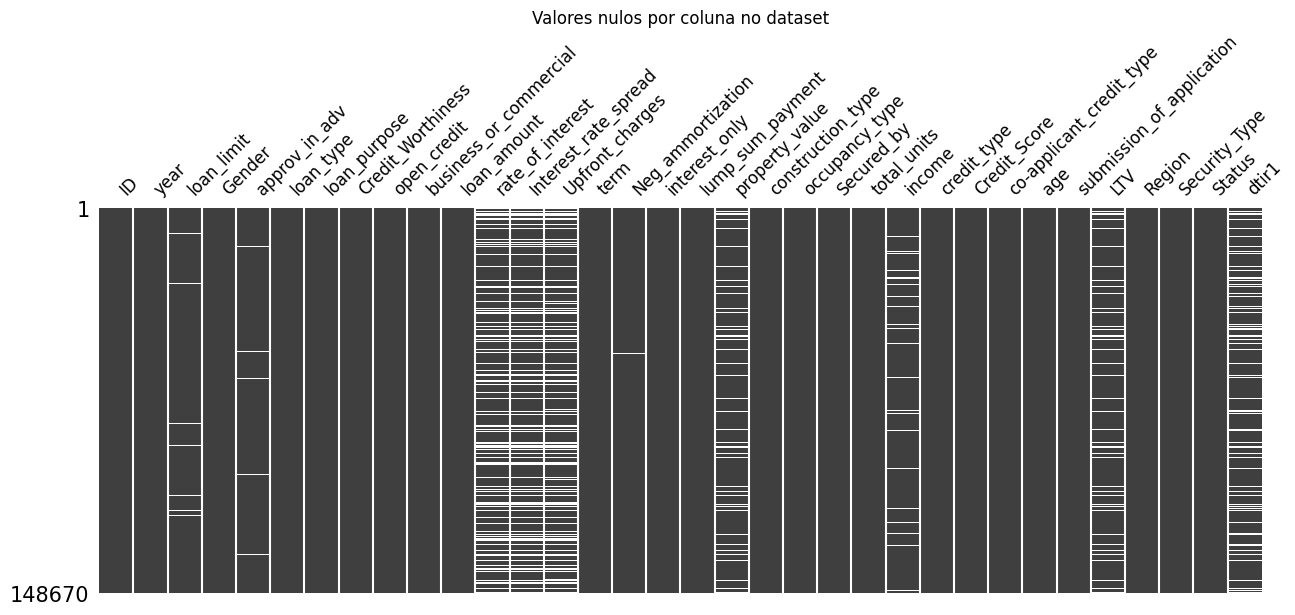

In [9]:
# Instalar pacote missingno
# pip install missingno

msno.matrix(df, figsize=(15, 5), fontsize=12, labels=True, sparkline=False)
plt.title('Valores nulos por coluna no dataset')
plt.show()

In [10]:
# Valores nulo quando Status = 0 ou = 1
df_status0 = df[df['Status'] == 0].copy()
df_status1 = df[df['Status'] == 1].copy()

indices = df_status1.isna().sum().index
valores_status0 = np.array(df_status0.isna().sum())
valores_status1 = np.array(df_status1.isna().sum())
df_valores_nulos = pd.DataFrame({'coluna': indices, 'Status 0': valores_status0, 'Status 1': valores_status1})
df_valores_nulos

,coluna,Status 0,Status 1
0,ID,0,0
1,year,0,0
2,loan_limit,2463,881
3,Gender,0,0
4,approv_in_adv,667,241
5,loan_type,0,0
6,loan_purpose,99,35
7,Credit_Worthiness,0,0
8,open_credit,0,0
9,business_or_commercial,0,0


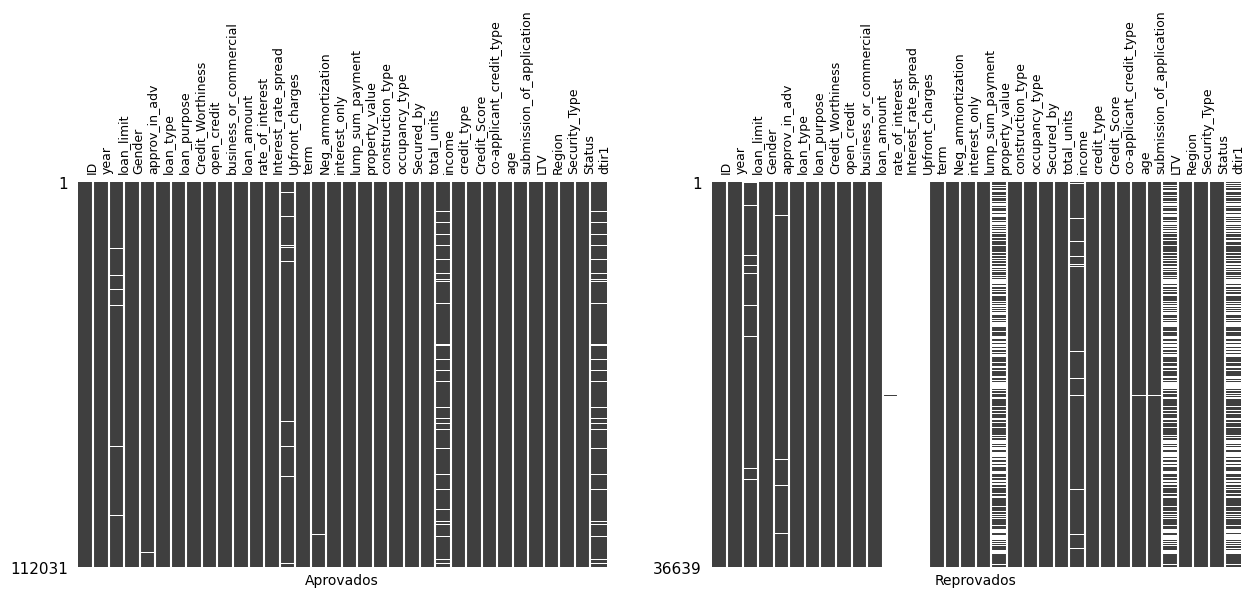

In [24]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,2,1)
msno.matrix(df_status0, fontsize=9, labels=True, sparkline=False, ax=ax1)
plt.xlabel('Aprovados')
plt.xticks(rotation=90)

ax2 = fig.add_subplot(1,2,2)
msno.matrix(df_status1, fontsize=9, labels=True, sparkline=False, ax=ax2)
plt.xlabel('Reprovados')
plt.xticks(rotation=90)

plt.show()

In [29]:
def porcentagem_nulos(df):
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_pct = {}
    
    for col in missing_columns:
        nulls = df[col].isnull().sum()
        pct = (nulls/df.shape[0]) * 100
        missing_pct[col] = pct
        print(f'{col}: {nulls} ({round(missing_pct[col], 2)}%)')
        

In [50]:
print('Nulos para Dataset Total')
porcentagem_nulos(df)
print()

print('Nulos para Aprovados')
porcentagem_nulos(df_status0)
print()

print('Nulos para Reprovados')
porcentagem_nulos(df_status1)

Nulos para Dataset Total
loan_limit: 3344 (2.25%)
approv_in_adv: 908 (0.61%)
loan_purpose: 134 (0.09%)
rate_of_interest: 36439 (24.51%)
Interest_rate_spread: 36639 (24.64%)
Upfront_charges: 39642 (26.66%)
term: 41 (0.03%)
Neg_ammortization: 121 (0.08%)
property_value: 15098 (10.16%)
income: 9150 (6.15%)
age: 200 (0.13%)
submission_of_application: 200 (0.13%)
LTV: 15098 (10.16%)
dtir1: 24121 (16.22%)

Nulos para Aprovados
loan_limit: 2463 (2.2%)
approv_in_adv: 667 (0.6%)
loan_purpose: 99 (0.09%)
Upfront_charges: 3156 (2.82%)
term: 26 (0.02%)
Neg_ammortization: 89 (0.08%)
property_value: 2 (0.0%)
income: 7911 (7.06%)
LTV: 2 (0.0%)
dtir1: 7811 (6.97%)

Nulos para Reprovados
loan_limit: 881 (2.4%)
approv_in_adv: 241 (0.66%)
loan_purpose: 35 (0.1%)
rate_of_interest: 36439 (99.45%)
Interest_rate_spread: 36639 (100.0%)
Upfront_charges: 36486 (99.58%)
term: 15 (0.04%)
Neg_ammortization: 32 (0.09%)
property_value: 15096 (41.2%)
income: 1239 (3.38%)
age: 200 (0.55%)
submission_of_application: 20

Analisando as informações acima, observamos que:
- Em ```rate_of_interest```, ```Interest_rate_spread```, ```Upfront_charges``` os dados nulos configuram >99% da coluna para **Status 1** (Reprovados)
- Em , ```property_value```, ```LTV``` e ```dtir1``` os nulos configuram ~40% da coluna para **Status 1** (Reprovados)
- As demais colunas com dados faltantes apresentam distribuições similares entre **Status 0** e **Status 1**

Podemos observar que os valores faltantes nas colunas 'rate_of_interest', 'interest_rate_spread' e 'Upfront_charges' estão fortemente ligadas ao Status de aprovação do empréstimo. Portanto, avaliamos possivelmente se tratarem de valores relacionados a processos pós-aprovação e decidimos por excluir essas colunas.

In [6]:
# Drop de colunas de ID, não informativas ou colunas que configuram 99% de dados faltantes para Status 1
df.drop(columns=['ID', 'year','rate_of_interest', 'Interest_rate_spread', 'Upfront_charges'], inplace=True)

# Drop de daados faltantes em colunas com menos de 5% dos dados totais e similarmente distribuidos entre Status 0 e Status 1
df.dropna(subset=['loan_limit', 'approv_in_adv', 'loan_purpose', 'term', 'Neg_ammortization', 'age', 'submission_of_application'], inplace=True) 

# PRÓXIMOS PASSOS: TRATAR CASOS DE COLUNAS COM ~40% DADOS FALTANTES
# tratamento com imputation após divisão do dataset em treino/teste

df.shape

(143942, 29)

In [7]:
df.isnull().sum().sort_values(ascending=False).head(12)

dtir1                        23305
LTV                          14597
property_value               14597
income                        8834
occupancy_type                   0
Status                           0
Security_Type                    0
Region                           0
submission_of_application        0
age                              0
co-applicant_credit_type         0
Credit_Score                     0
dtype: int64

In [10]:
df[['dtir1', 'LTV', 'property_value', 'income']].dtypes

dtir1             float64
LTV               float64
property_value    float64
income            float64
dtype: object

- Sobraram apenas valores faltantes em colunas numéricas.

### Atualização de passos: (APAGAR PARA APRESENTAÇÃO)
Se utilizarmos o KNNImputer sugerido pelo Fernando, os passos a serem seguidos no dataset serão:
- Divisão do dataset em treino e teste (podemos manter o X e y juntos como o professor mostrou na última aula)
- Pipeline/ColumnTransformer com:
    - Scaler (Observar distribuição de dados e outliers (precisamos fazer um boxplot com as variáveis numéricas) para escolher o melhor scaler)
    - OneHot/Ordinal encoder para transformação das colunas categóricas em número
    - KNNImputer para preenchimento dos dados faltantes
- 2 primeiros passos pode ser um column transformer, o 3o passo precisa seguir num pipeline após os 2 primeiros
- fit_transform no X_train, transform no X_test

In [11]:
# O que May mandou no grupo e concordo: 
#       "Tem aquelas 33 amostras que são distoantes do resto do dataset pra várias colunas diferentes. Podemos simplesmente excluir essas linhas.
#        E aí tem algumas colunas que a variação é só essa dos 33 e poderíamos dropar elas.

# df = df[df["construction_type"] != "mh"]
# df.drop(columns=["construction_type", "Secured_by", "Security_Type"], inplace=True)

# Pensando melhor, como a informação é pequena, acho que não vai trazer grandes prejuízos rodar o modelo com essas colunas.
# De qualquer forma, acho que elas serão filtradas na feature selection
# (apagar essa célula se não usarmos o código e limpar pra apresentação, se usarmos)

In [12]:
# Talvez antes de separa em treino/teste deveríamos fazer uma subsample dos dados com status = 0. Pra balancear um pouco mais os dados.

In [13]:
X = df.drop(columns='Status')
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Tratamento dos dados faltantes

**Plano de Ação:** (Apagar antes da apresentação)

Preencher os dados faltantes com que estratégia?
- Média de cada feature?
- Igual a zero ?
- kNN imputation: estratégia que li [nessa matéria](https://www.blog.dailydoseofds.com/p/the-most-overlooked-problem-with-768?utm_source=post-email-title&publication_id=1119889&post_id=135561523&isFreemail=true&utm_medium=email) de uma newsletter que sigo

<img src='https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F0d8bb4da-0c62-4492-8dfd-b30f5530d8ca_2973x3153.jpeg' width='500'>

In [15]:
# Separando as features de acordo com os tratamentos

# Features categóricas nominais: 
# precisa tratar: apenas ['loan_purpose'] 
features_cat = list(df.select_dtypes(exclude=np.number).columns)
features_cat.remove('total_units')
features_cat.remove('age')

# Define a ordem para o OrdinalEncoder
units_order = ['1U', '2U', '3U', '4U']
age_order = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74']
# Features categóricas ordinais: 
features_ord = ['total_units','age']


# Features numéricas:
# precisa tratar: Upfront_charges, rate_of_interest, Interest_rate_spread, dtir1, property_value, LTV, income
features_num = list(df.select_dtypes(include=np.number).columns)
features_num.remove('Status')

In [16]:
#Criando pipelines
# Rever necessidade de cada Pipeline, já que não há mais dados faltantes nas colunas categóricas.
pipe_feat_cat = Pipeline([
    ('input_cat', SimpleImputer(strategy = "most_frequent")), # Não tem mais necessidade. Sem nans
    ('encod_cat', OneHotEncoder(drop='first', sparse_output=False))
])

pipe_feat_ord = Pipeline([
    ('encod_ord', OrdinalEncoder(categories=[units_order, age_order]))
])

pipe_feat_num = Pipeline([
    ('scaler', RobustScaler()), # Considerar PowerTransformer() (sklearn.preprocessing) para transformar os dados numa escala Log e corrigir a skwedness.
    ('input_num', KNNImputer(n_neighbors = 2)) # Opção 2: ('input_num', SimpleImputer(strategy = "mean")) (troquei pra knnimputer)
])

# Aplica cada pipeline nas respectivas colunas
pre_processamento = ColumnTransformer([
        ('transf_cat', pipe_feat_cat, features_cat),
        ('transf_ord', pipe_feat_ord, features_ord),
        ('transf_num', pipe_feat_num, features_num)
], remainder='passthrough')

# Para que o output seja um datafram do pandas
pre_processamento.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('transf_cat',
                                 Pipeline(steps=[('input_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encod_cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['loan_limit', 'Gender', 'approv_in_adv',
                                  'loan_type', 'loan_purpose',
                                  'Credit_Worthiness', 'open_credit',
                                  'business_or_commercial', 'Neg_ammortization',
                                  '...
                                                  OrdinalEncoder(categories=[['1U',
                                                                              '2U',
                                                                              '3U',
                                                                              '4U'],
                                                                             ['<25',
                                                                              '25-34',
                                                                              '35-44',
                                                                              '45-54',
                                                                              '55-64',
                                                                              '65-74',
                                                                              '>74']]))]),
                                 ['total_units', 'age']),
                                ('transf_num',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('input_num',
                                                  SimpleImputer())]),
                                 ['loan_amount', 'rate_of_interest',
                                  'Interest_rate_spread', 'Upfront_charges',
                                  'term', 'property_value', 'income',
                                  'Credit_Score', 'LTV', 'dtir1'])])

In [17]:
# Column Transform: dados de treino
X_train_transformed = pre_processamento.fit_transform(X_train)

new_columns = list(X_train_transformed.columns)
for column in range(len(new_columns)):
    new_columns[column] = new_columns[column][12:]

X_train_transformed.columns = new_columns

X_train_transformed.head(3)

,loan_limit_ncf,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_pre,loan_type_type2,loan_type_type3,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,Credit_Worthiness_l2,open_credit_opc,business_or_commercial_nob/c,Neg_ammortization_not_neg,interest_only_not_int,lump_sum_payment_not_lpsm,occupancy_type_pr,occupancy_type_sr,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_EXP,submission_of_application_to_inst,Region_North-East,Region_central,Region_south,total_units,age,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1
80716,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.625,-0.320000,-0.469964,0.424464,0.0,0.485714,-0.1500,-0.089552,0.031917,-0.071429
12817,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.625,-0.486667,-0.083011,0.581491,-180.0,0.514286,15.7125,0.203980,-0.017282,-1.428571
37515,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.250,0.064996,0.073517,0.146875,0.0,0.232409,0.2250,-0.164179,-0.093862,-0.090063


In [18]:
X_train_transformed.describe()

,loan_limit_ncf,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_pre,loan_type_type2,loan_type_type3,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,Credit_Worthiness_l2,open_credit_opc,business_or_commercial_nob/c,Neg_ammortization_not_neg,interest_only_not_int,lump_sum_payment_not_lpsm,occupancy_type_pr,occupancy_type_sr,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_EXP,submission_of_application_to_inst,Region_North-East,Region_central,Region_south,total_units,age,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1
count,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.00000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000,115127.000000
mean,0.068576,0.279795,0.283530,0.252721,0.159780,0.138100,0.100150,0.021941,0.376497,0.371598,0.044082,0.003639,0.861900,0.900597,0.952956,0.976626,0.930181,0.021029,0.295726,0.101288,0.278953,0.500100,0.645088,0.008443,0.057910,0.430950,0.020933,3.14021,0.147161,0.064996,0.073517,0.146875,-24.948144,0.232409,0.250918,0.002826,-0.093862,-0.090063
std,0.252734,0.448901,0.450714,0.434574,0.366404,0.345006,0.300202,0.146492,0.484509,0.483234,0.205278,0.060218,0.345006,0.299204,0.211733,0.151089,0.254842,0.143481,0.456370,0.301711,0.448486,0.500002,0.478489,0.091497,0.233574,0.495211,0.194819,1.41751,0.764115,0.652292,0.639339,0.655226,58.451887,0.970962,1.332348,0.577427,1.438230,0.688449
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1.166667,-5.320000,-5.771039,-0.614920,-264.000000,-1.171429,-1.200000,-0.990050,-2.872722,-2.428571
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.00000,-0.416667,-0.320000,-0.299642,-0.320817,0.000000,-0.371429,-0.400000,-0.497512,-0.463654,-0.428571
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.00000,0.000000,0.064996,0.073517,0.146875,0.000000,0.114286,0.050000,0.000000,-0.084566,-0.090063
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.00000,0.583333,0.346667,0.328602,0.306858,0.000000,0.514286,0.525000,0.502488,0.370483,0.357143
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,6.00000,13.666667,5.346667,4.257634,8.428751,0.000000,45.971429,119.337500,1.000000,300.512342,1.571429


In [19]:
# Column Transform: dados de treino
X_test_transformed = pre_processamento.transform(X_test)

new_columns = list(X_test_transformed.columns)
for column in range(len(new_columns)):
    new_columns[column] = new_columns[column][12:]

X_test_transformed.columns = new_columns

X_test_transformed.head(2)

,loan_limit_ncf,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_pre,loan_type_type2,loan_type_type3,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,Credit_Worthiness_l2,open_credit_opc,business_or_commercial_nob/c,Neg_ammortization_not_neg,interest_only_not_int,lump_sum_payment_not_lpsm,occupancy_type_pr,occupancy_type_sr,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_EXP,submission_of_application_to_inst,Region_North-East,Region_central,Region_south,total_units,age,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1
2661,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,1.791667,1.333333,0.416631,0.510349,0.0,2.085714,0.6625,-0.273632,-0.458263,0.142857
14325,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.583333,1.013333,0.568602,-0.614920,0.0,0.142857,0.7875,0.666667,0.703519,-0.214286


### Análise do target

In [20]:
#Fazer a análise nos dados de treino
treino = pd.concat([X_train_transformed, y_train], axis=1)

print(treino.shape)
treino.head()

(115127, 39)


,loan_limit_ncf,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_pre,loan_type_type2,loan_type_type3,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,Credit_Worthiness_l2,open_credit_opc,business_or_commercial_nob/c,Neg_ammortization_not_neg,interest_only_not_int,lump_sum_payment_not_lpsm,occupancy_type_pr,occupancy_type_sr,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_EXP,submission_of_application_to_inst,Region_North-East,Region_central,Region_south,total_units,age,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1,Status
80716,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.625000,-0.320000,-0.469964,0.424464,0.0,0.485714,-0.1500,-0.089552,0.031917,-0.071429,0
12817,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.625000,-0.486667,-0.083011,0.581491,-180.0,0.514286,15.7125,0.203980,-0.017282,-1.428571,0
37515,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.250000,0.064996,0.073517,0.146875,0.0,0.232409,0.2250,-0.164179,-0.093862,-0.090063,1
82366,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.125000,0.180000,1.281147,-0.541030,0.0,-0.200000,-0.3875,-0.263682,0.724930,0.428571,0
74273,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,5.0,-0.291667,0.064996,0.073517,0.146875,0.0,-0.342857,-0.3250,0.238806,0.034681,0.357143,1


In [21]:
treino['Status'].value_counts(normalize=True)

Status
0    0.755244
1    0.244756
Name: proportion, dtype: float64

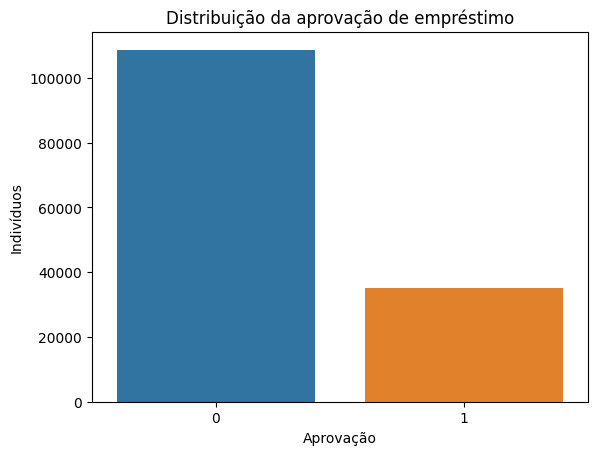

In [22]:
# Análise de balanceamento do target do dataset
sns.countplot(data=df, x='Status')
plt.title('Distribuição da aprovação de empréstimo')
plt.ylabel('Indivíduos')
plt.xlabel('Aprovação')
plt.show()
# df['Status'].value_counts(normalize=True).plot(kind='bar', title='Distribuição da aprovação de empréstimo',
#                                                ylabel='Porcentagem',
#                                                xlabel='Aprovação')

Nosso target ```Status``` é desbalanceado, podemos pensar em maneira de equilibrar a distribuição. 

Ideias:

- *Undersampling:* remover parte das observações da classe 0 para balancear. Sugestão, algo em torno de 60-40% acho que já seria OK.
- *Oversamplig:* criar dados sintéticos para a classe 1, até um o momento de criar uma distribuição mais balanceada.

Como temos um bom valor na classe 1, acredito que o *undersampling* já nos ajude, para evitar a criação de dados sintéticos.

## 2. Visualização das distribuições

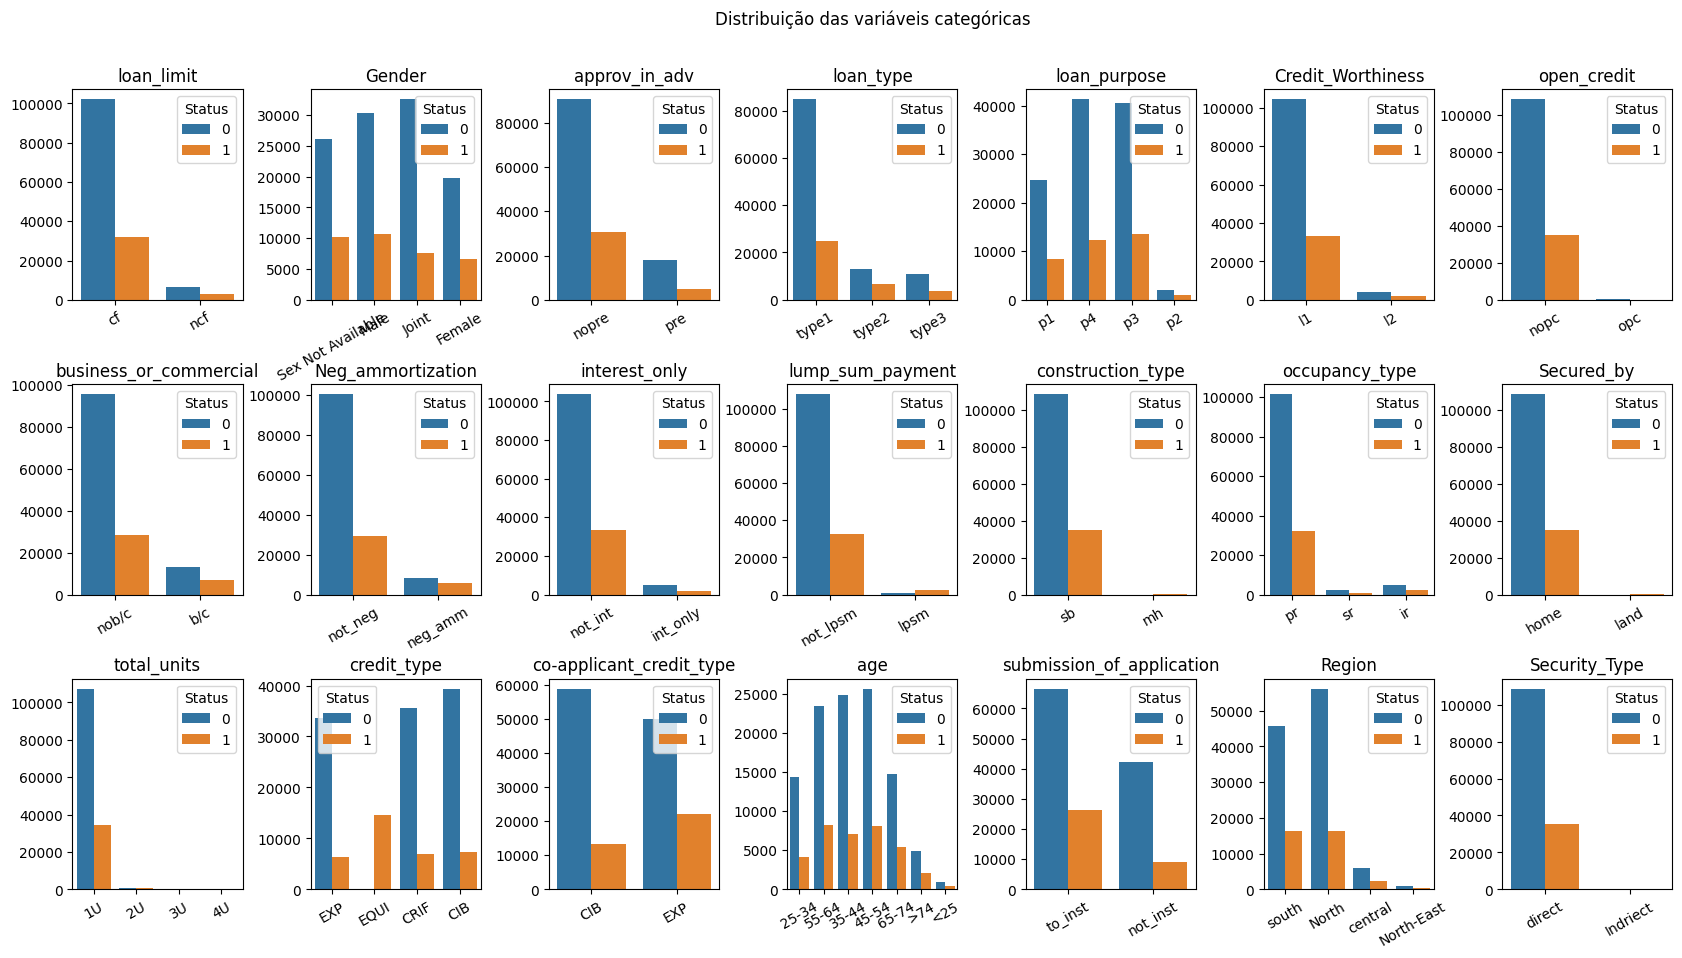

In [22]:
# Distribuição das variáveis categóricas
category_list = ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
                 'Credit_Worthiness', 'open_credit', 'business_or_commercial',
                 'Neg_ammortization', 'interest_only', 'lump_sum_payment',
                 'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
                 'credit_type', 'co-applicant_credit_type', 'age',
                 'submission_of_application', 'Region', 'Security_Type']
count = 1
fig = plt.figure(figsize=(20,10))

for category in category_list:
    fig.add_subplot(3,7, count)
    sns.countplot(data = df,
                  x=category, 
                  hue='Status')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(rotation=30)
    plt.title(category)
    count += 1
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    
plt.suptitle('Distribuição das variáveis categóricas')
plt.show()

In [17]:
df.select_dtypes(include=np.number).columns

Index(['loan_amount', 'term', 'property_value', 'income', 'Credit_Score',
       'LTV', 'Status', 'dtir1'],
      dtype='object')

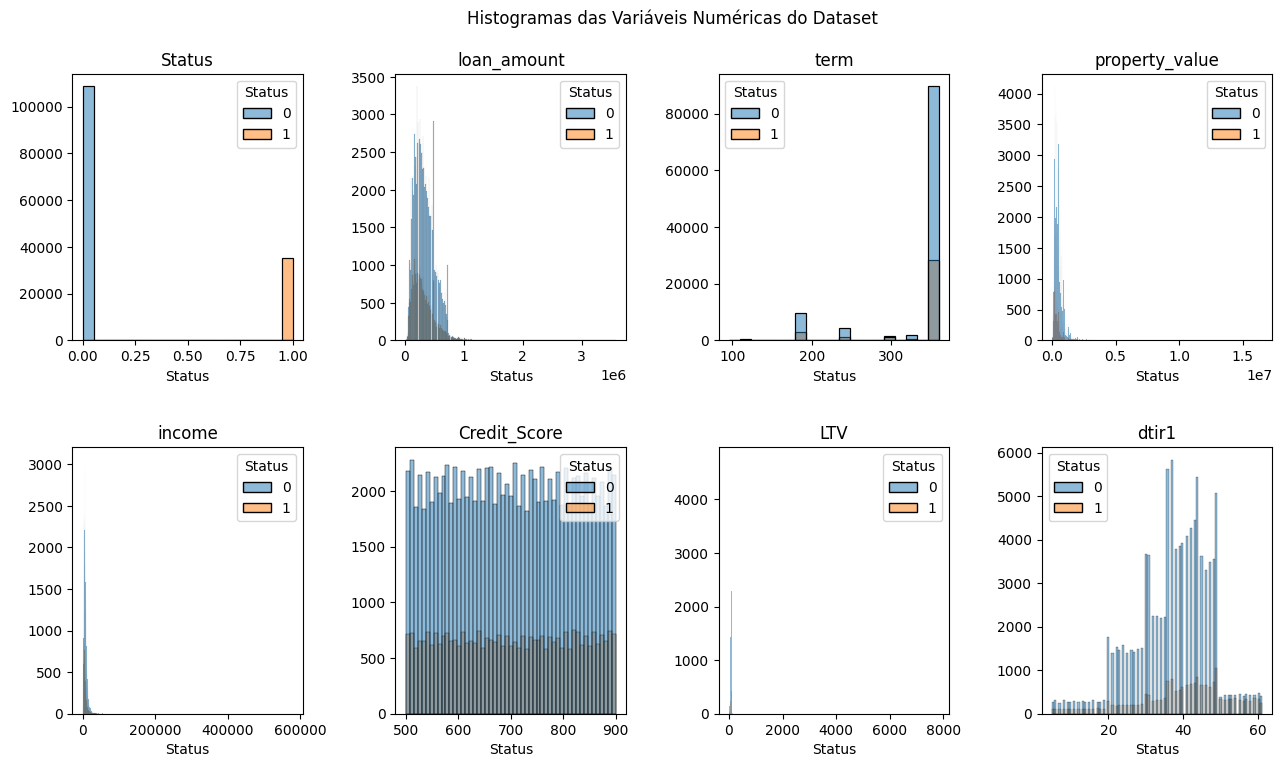

In [20]:
# Histograma das features
numeric_list = ['Status', 'loan_amount', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']

fig= plt.figure(figsize=(15,8))

for number, category in enumerate(numeric_list, start=1):
    ax = fig.add_subplot(2,4,number)
    sns.histplot(data=df, x=category, hue='Status')
    plt.title(category)
    plt.xlabel('Status')
    ax.set_ylabel('')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.suptitle('Histogramas das Variáveis Numéricas do Dataset')
plt.show()

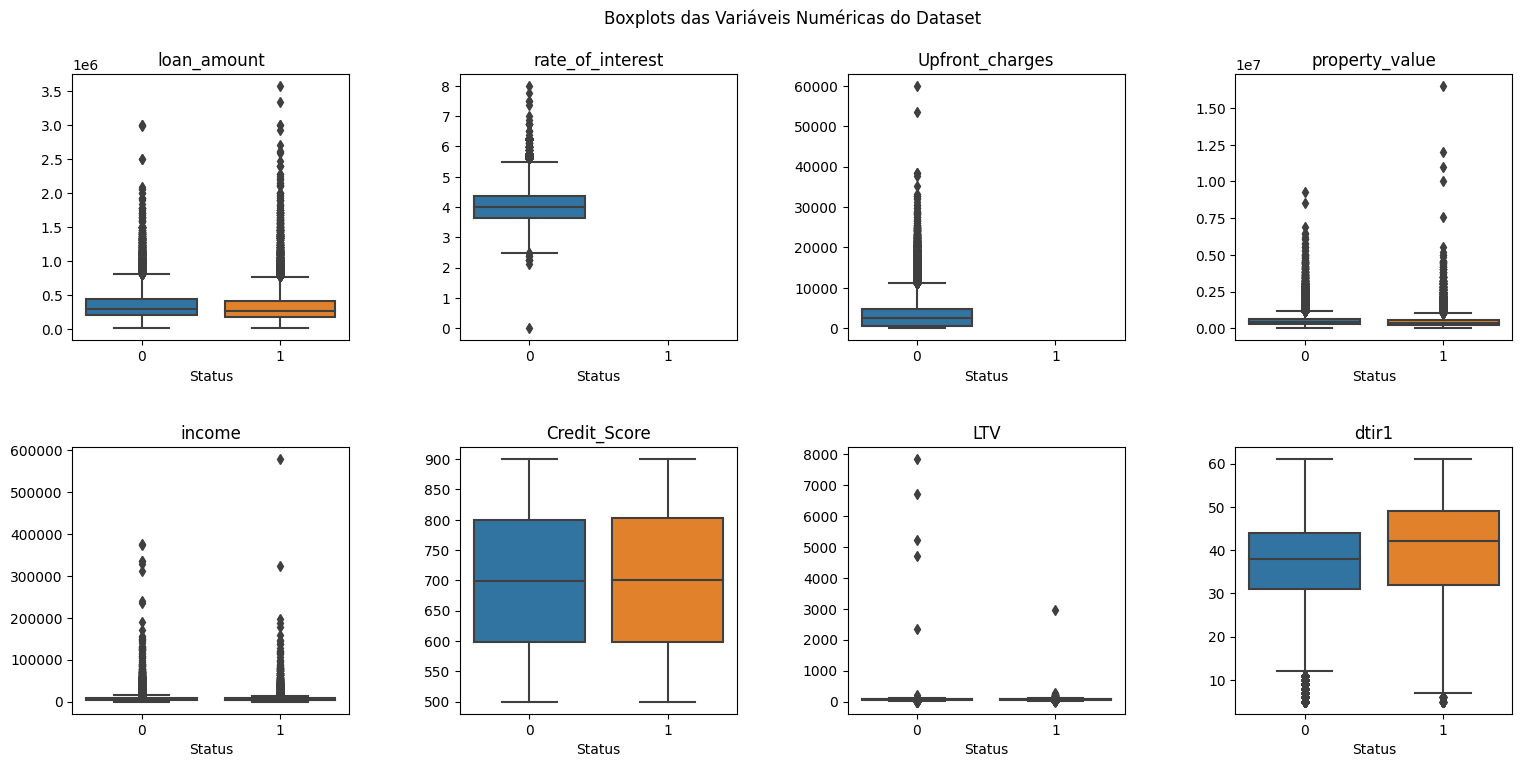

In [24]:
# Boxplot das features

fig= plt.figure(figsize=(18,8))

for number, category in enumerate(numeric_list, start=1):
    ax = fig.add_subplot(2,4,number)
    sns.boxplot(data=df, y=category, x='Status')
    plt.title(category)
    plt.xlabel('Status')
    ax.set_ylabel('')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.suptitle('Boxplots das Variáveis Numéricas do Dataset')
plt.show()

Analisando os dados expressos nos boxplots acima, além do fato de várias features apresentarem vários outliers, nenhuma distribuição se destaca.

Apenas ```dtir1``` tem uma leve disparidade no intervalo interquatil.

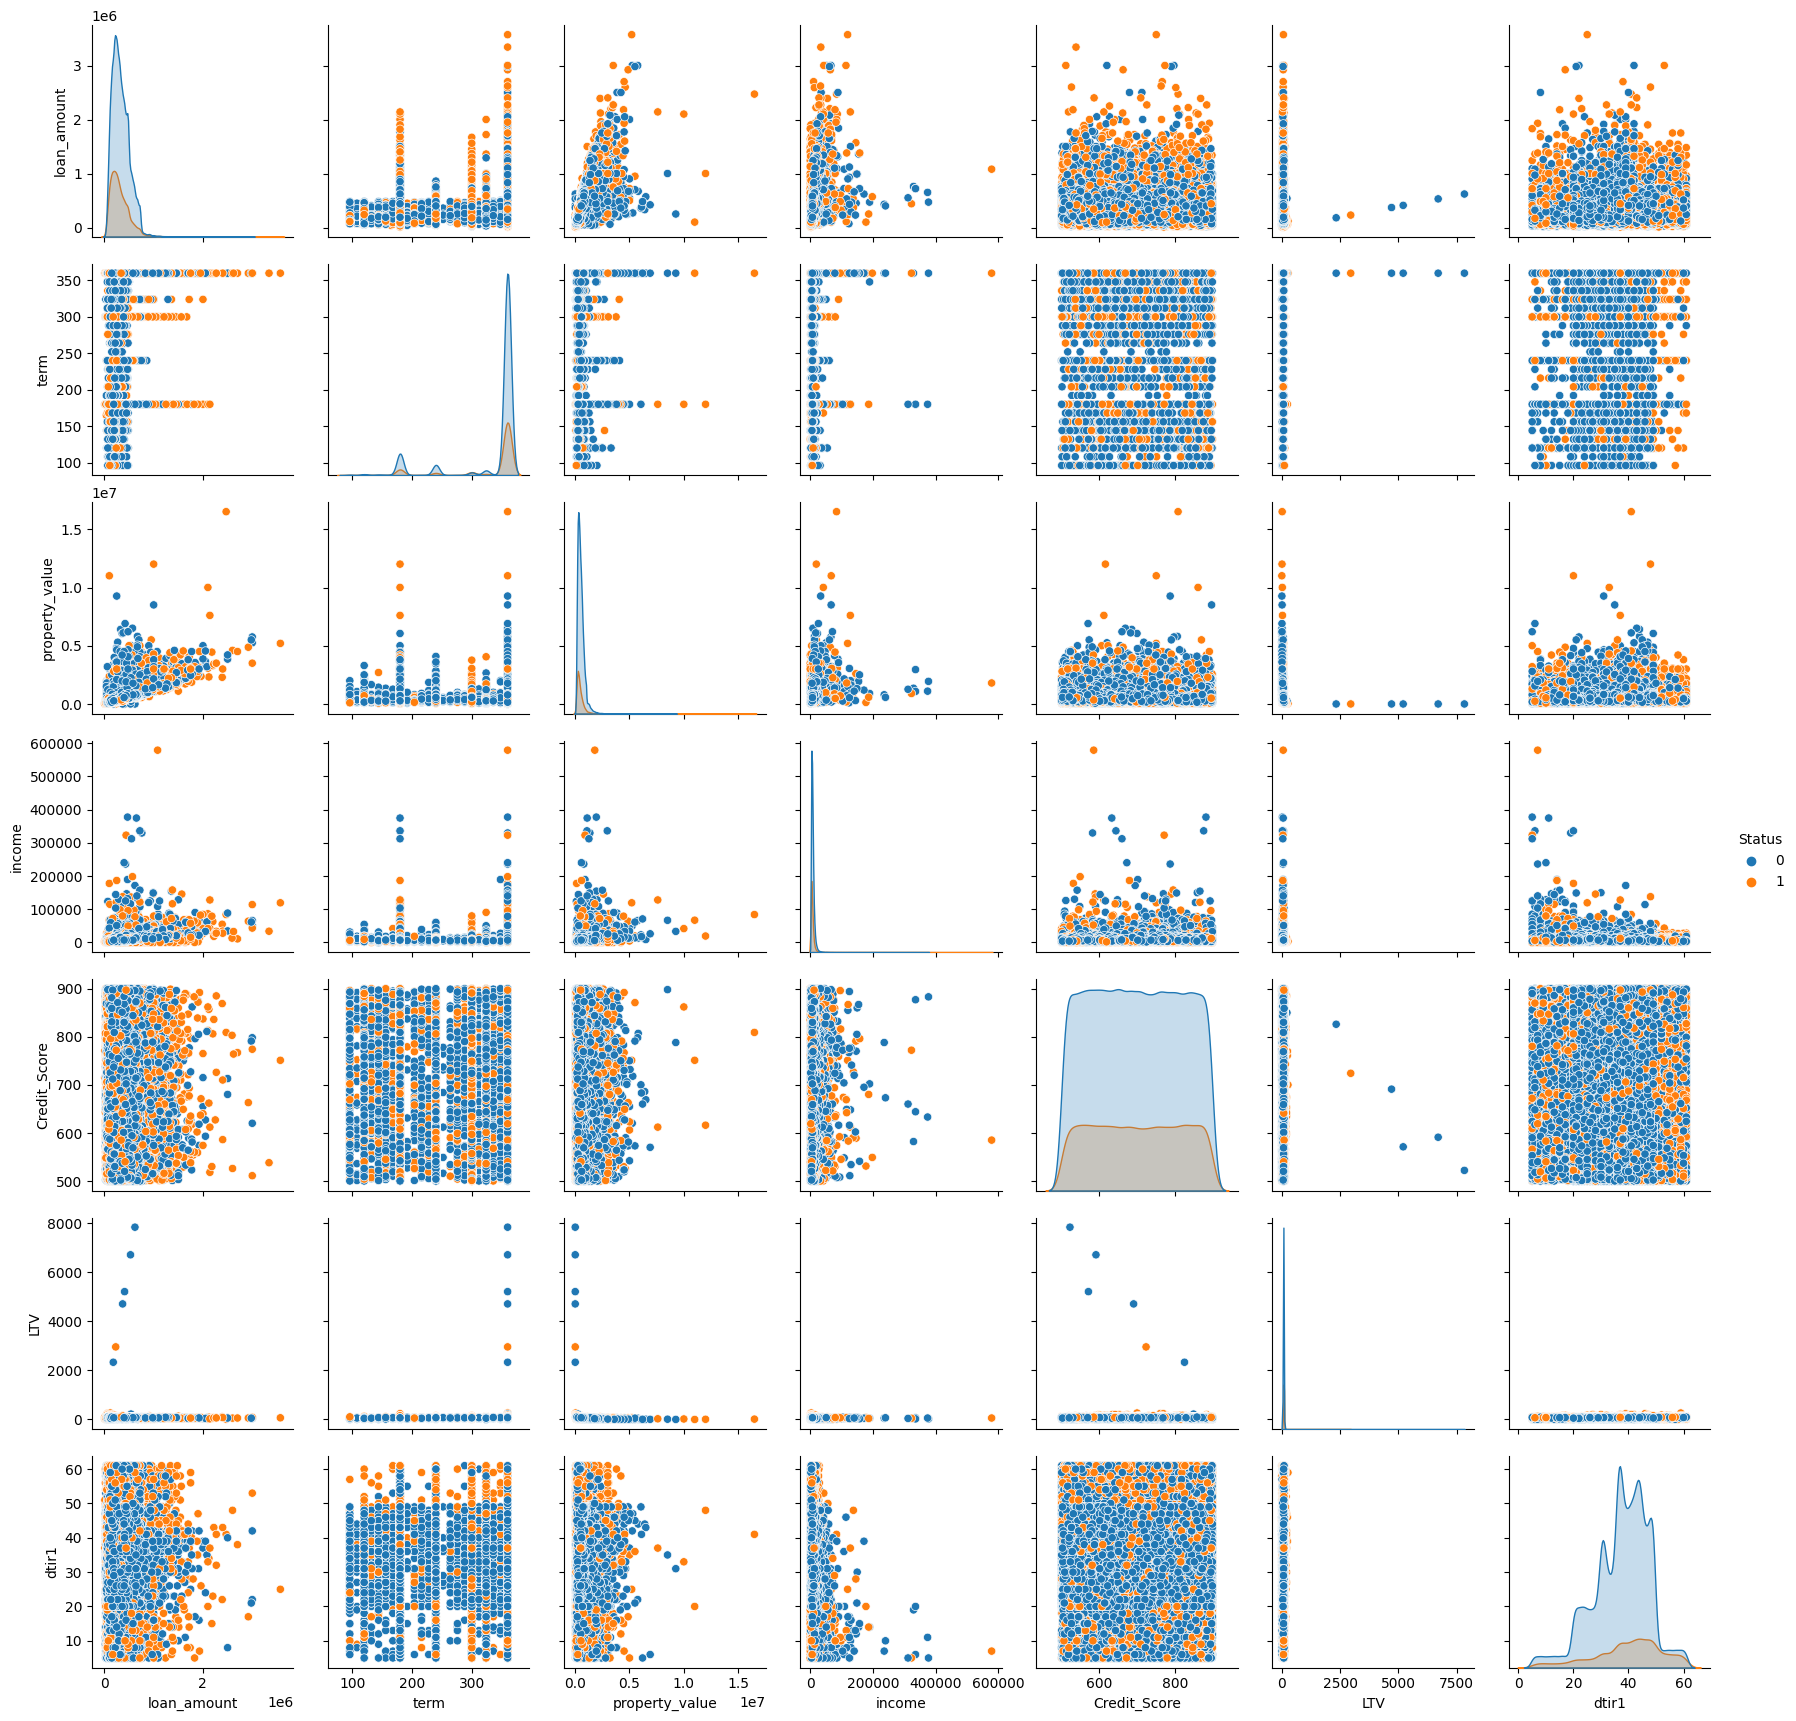

In [11]:
sns.pairplot(data=df, hue='Status')

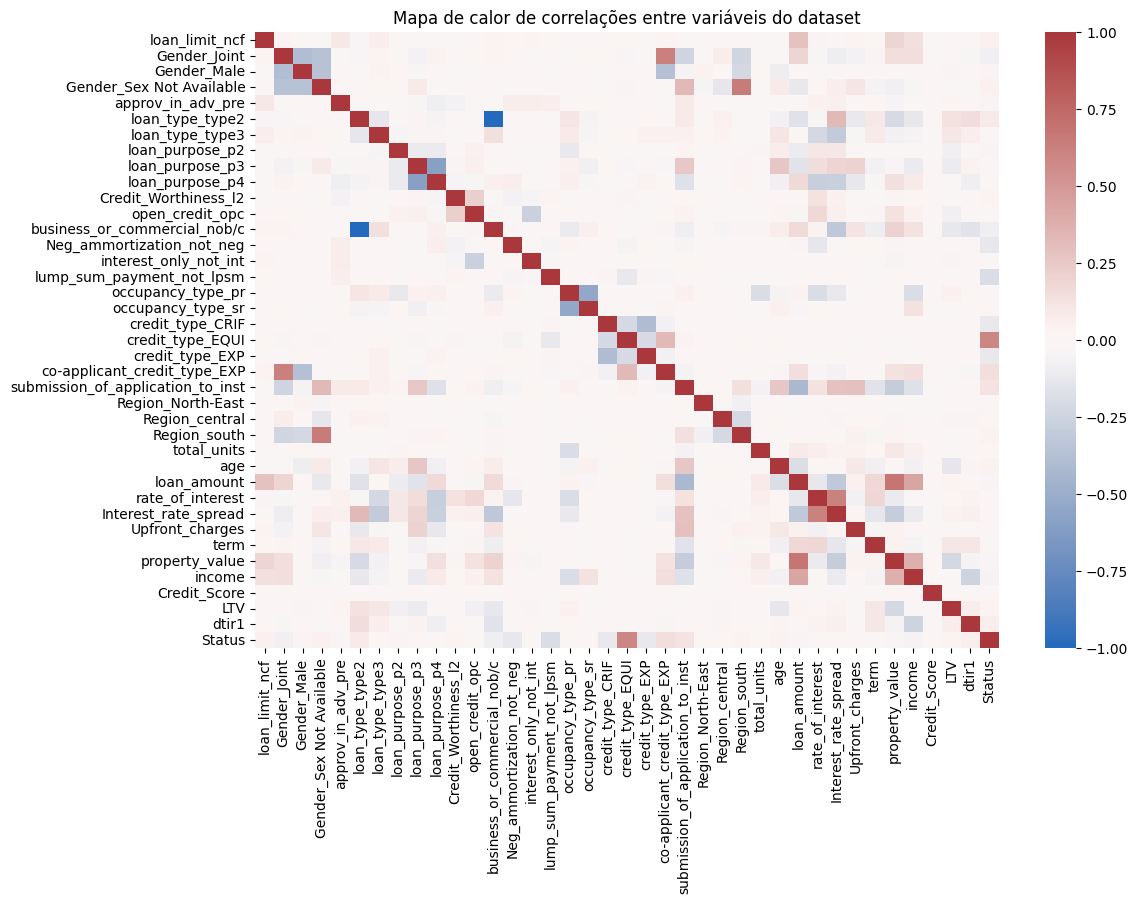

In [25]:
X_treino = X_train_transformed.copy()
X_treino['Status'] = y_train

# Correlação e heatmap das features e target
plt.figure(figsize=(12,8))
sns.heatmap(treino.corr(), cmap='vlag')
plt.title('Mapa de calor de correlações entre variáveis do dataset')
plt.xticks(rotation=90)
plt.show()

In [26]:
# Valores Status = 0 ou = 1
df_status0 = df[df['Status'] == 0].copy()
df_status1 = df[df['Status'] == 1].copy()

indices = df_status1.isna().sum().index
valores_status0 = np.array(df_status0.sum())
valores_status1 = np.array(df_status1.sum())
df_valores_status = pd.DataFrame({'coluna': indices, 'Status 0': valores_status0, 'Status 1': valores_status1})

In [27]:
# Será que as colunas abaixo devam ser removidas ? 
# Elas só apresentam dados para o Status = 0, e não para o Status = 1.
# Abaixo está a média de cada coluna, separado em status
df_valores_status.loc[9:11]

,coluna,Status 0,Status 1
9,rate_of_interest,439069.675,0.0
10,Interest_rate_spread,47645.0459,0.0
11,Upfront_charges,341377243.6,0.0


### Seleção de Features

In [49]:
# X_train_transformed
# X_test_transformed
# y_train, y_test

- Lasso

In [52]:
estimador_lasso = Lasso(random_state=42)

estimador_lasso.fit(X_train_transformed, y_train)

estimador_lasso.coef_

array([ 0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0.,
       -0., -0., -0., -0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0.])

- Permutation Importance

In [42]:
estimador = DecisionTreeClassifier().fit(X_train_transformed, y_train)

permutacao = permutation_importance(estimador, X_test_transformed, y_test, random_state=42)

In [48]:
dados = {
    'importancia': permutacao.importances_mean,
    'std': permutacao.importances_std
}

importancia = pd.DataFrame(dados, index=estimador.feature_names_in_).sort_values(by='importancia', ascending=False).head(10)
importancia

,importancia,std
rate_of_interest,0.292412,0.002235
credit_type_EQUI,0.050351,0.000553
property_value,0.043784,0.000802
LTV,0.000000,0.000000
age,0.000000,0.000000
co-applicant_credit_type_EXP,0.000000,0.000000
submission_of_application_to_inst,0.000000,0.000000
Region_North-East,0.000000,0.000000
Region_central,0.000000,0.000000
Region_south,0.000000,0.000000


- RFECV

In [66]:
# Tentei ajustar o valor de max_iter porque ao rodar aparecia o aviso.
# Cheguei a 600 e continua mostrando o aviso. Cuidar ao rodar ou mudar o max_iter,
# pq aumenta bastante tbm o tempo de processamento quanto maior o valor.
estimador_rfecv = LogisticRegression(max_iter=600)
rfecv = RFECV(estimador_rfecv, cv=5, verbose=1)

rfecv.fit(X_train_transformed, y_train)

Fitting estimator with 38 features.


c:\Users\Mayara\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 fe

c:\Users\Mayara\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 fe

RFECV(cv=5, estimator=LogisticRegression(max_iter=600), verbose=1)

In [68]:
# Mesmo mudando o max_iter, as features não mudaram
rfecv.n_features_

38

In [64]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

- PCA sem feature selection

(Adaptar o X se usarmos alguma feature selection)

In [74]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X_train_transformed)

PCA(n_components=2, random_state=42)

In [75]:
pca.explained_variance_ratio_

array([9.96333944e-01, 7.21368866e-04])

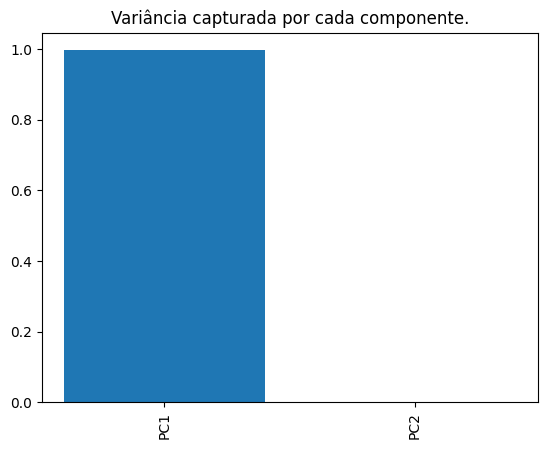

In [76]:
labels = [f'PC{i+1}' for i in range(pca.n_components_)]
plt.bar(labels, pca.explained_variance_ratio_)
plt.title("Variância capturada por cada componente.")
plt.xticks(rotation=90)
plt.show()

In [79]:
X_train_pca = pca.transform(X_train_transformed)

In [82]:
treino_temp = treino.reset_index(drop=True)

treino_pca = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])

treino_pca['Status'] = treino_temp['Status']

treino_pca.head()


,PC1,PC2,Status
0,-24.950723,0.069992,0
1,155.067044,12.058518,0
2,-24.949056,0.078400,1
3,-24.951840,-1.007935,0
4,-24.943086,-1.513685,1


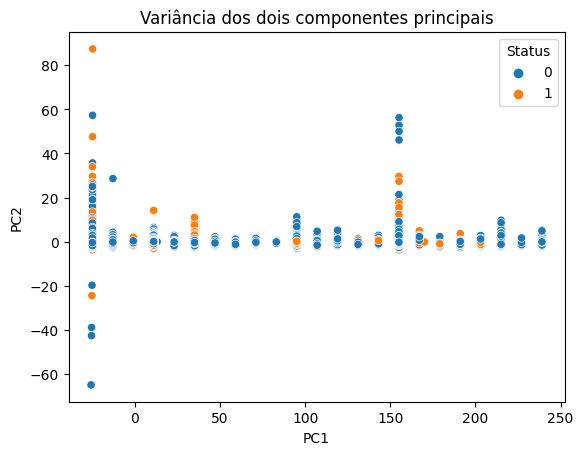

In [85]:
sns.scatterplot(data=treino_pca,
                x="PC1", y="PC2",
                hue="Status")
plt.title('Variância dos dois componentes principais')
plt.show()

### Modelos

- Logistic Regression

- Outro Modelo

- Mais um Modelo